In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
from keras import layers, regularizers
#from keras import models
from keras.models import Model, Sequential
from keras import callbacks
from time import time
from keras import backend as K
#import tensorflow as tf
K.set_image_data_format("channels_first")
import tensorflow as tf
from skimage import morphology
from keras.preprocessing import image

history = []
xaxis = []
modelList = []

Using TensorFlow backend.


In [2]:
nBatch = 98
tile_size = np.array([108,108]) # approximaively 325/3, which make 9 validation images out of one image

MeanMul = np.array([273.0986182,  419.76840769, 555.64225385, 415.04076728, 398.17880738, 392.73360337, 520.6677288,  332.93299056])
StdMul = np.array([103.36328929, 212.07958314, 328.75655985, 277.91317343, 286.29950289, 246.1132603,  331.64955449, 212.41048715])
MeanPan = 532.15765512
StdPan = 321.67303138
def trans(x, shape,theta,axis,x_start,y_start,tile_size):
    newx = np.empty((shape[0],shape[1],tile_size[0],tile_size[1]))
    for i in range(shape[0]):
        # rotation
        rotation_matrix = np.array([[np.cos(theta[i]), -np.sin(theta[i]), 0],
                                  [np.sin(theta[i]), np.cos(theta[i]), 0], [0, 0, 1]])
        m = image.transform_matrix_offset_center(rotation_matrix, shape[2], shape[3])
        x[i] = image.apply_transform(x[i], m, channel_axis=0, fill_mode='constant', cval=0)
            
        # tile
        newx[i] = x[i,:,x_start[i]: x_start[i]+tile_size[0], y_start[i]: y_start[i]+tile_size[1]]
        
        # The rotation should be first since it will make that we can have a rotation without black if it's in the center.
        # The rest should be afterward since it will be faster to do it on the tile
        
        # flips
        if axis[i] != 0:
            tmp = newx[i].swapaxes(axis[i], 0)
            tmp = tmp[::-1, ...]
            newx[i] = tmp.swapaxes(0, axis[i])
    return newx

def generator(batchsize, tile_size):
    while True:
        for i in range(nBatch):
            #print('  file', i)
            xMul = np.load(r'..\data\xMul'+str(i)+'.npy')
            xPan = np.load(r'..\data\xPan'+str(i)+'.npy')
            y = np.load(r'..\data\yWide_'+str(i)+'.npy')[:,np.newaxis,:,:] # create a channel axis of 1
            xMul = (xMul - MeanMul[:,np.newaxis,np.newaxis])/StdMul[:,np.newaxis,np.newaxis]
            xPan = (xPan - MeanPan)/StdPan
            
            theta = np.random.uniform(-np.pi, np.pi,len(xMul))
            axis = np.random.randint(0, 3, len(xMul))# choose to not flip (0), flip x (1), flip y (2)
            x_start = np.random.randint(0, xMul.shape[2] - tile_size[0],len(xMul))
            y_start = np.random.randint(0, xMul.shape[3] - tile_size[1],len(xMul))
            
            xMul = trans(xMul,xMul.shape,theta,axis,x_start,y_start,tile_size)
            xPan = trans(xPan,xPan.shape,theta,axis,4*x_start,4*y_start,4*tile_size)
            y = trans(y,y.shape,theta,axis,x_start,y_start,tile_size)
            
            # do more dilatations to remove the black spot that appears in the street
            for i in range(len(y)):
                for _ in range(2):
                    y[i] = morphology.binary_dilation(y[i])
            
            # brightness is changed by multiplying with a constant
            # Multiplying all channel of xMul by a constant might not correspond to real change in brightness due to movement
            # of the sun, but it's the best approximation I can think of.
            u = np.random.normal(loc=1.02, scale=0.12, size=len(xMul))
            xPan = xPan*u[:,np.newaxis,np.newaxis,np.newaxis]
            xMul = xMul*u[:,np.newaxis,np.newaxis,np.newaxis]
            
            j=0
            while j<xMul.shape[0]:
                #print('    ',j, '/', xMul.shape[0])
                yield ([xMul[j:j+batchsize], xPan[j:j+batchsize]], y[j:j+batchsize].reshape((-1,tile_size[0]*tile_size[1])))
                j+= batchsize
                
# Val should always be the same, so I'm just taking all the tiles, there are 5*64 in 325
nBatchVal = 11 # 11 batches of 9
def Val_generator(batchsize, tile_size):
    while True:
        for batch in range(nBatchVal):
            xMul = np.load(r'..\data\xMulVal'+str(batch)+r'.npy')
            xPan = np.load(r'..\data\xPanVal'+str(batch)+r'.npy')
            y = np.load(r'..\data\yVal'+str(batch)+r'.npy')
            xMul = (xMul - MeanMul[:,np.newaxis,np.newaxis])/StdMul[:,np.newaxis,np.newaxis]
            xPan = (xPan - MeanPan)/StdPan
            
            # do more dilatations to be like the training set
            for i in range(len(y)):
                for _ in range(2):
                    y[i] = morphology.binary_dilation(y[i])
            
            j=0
            while j<xMul.shape[0]:
                for ix in range(325//tile_size[0]):
                    for iy in range(325//tile_size[1]):
                        yield ([xMul[j:j+batchsize,:,ix*tile_size[0]:(ix+1)*tile_size[0],
                          iy*tile_size[1]:(iy+1)*tile_size[1]], 
                          xPan[j:j+batchsize,:,4*ix*tile_size[0]:4*(ix+1)*tile_size[0],4*iy*tile_size[1]:4*(iy+1)*tile_size[1]]], 
                          y[j:j+batchsize,ix*tile_size[0]:(ix+1)*tile_size[0],iy*tile_size[1]:(iy+1)*tile_size[1]]
                           .reshape((-1,tile_size[0]*tile_size[1])))
                j+= batchsize

In [3]:
# axis 1 is the area, axis 0 is the batch
def IoU_metrics(y_true, y_pred):
    return K.mean(K.sum(y_pred*y_true,axis=1)/(K.sum(y_pred,axis=1)+K.sum(y_true,axis=1)-K.sum(y_pred*y_true,axis=1)),axis=0)

class TimeHistory(callbacks.Callback):
    def __init__(self, seconds=np.inf):
        super(callbacks.Callback, self).__init__()
        self.seconds = seconds
    def on_train_begin(self, logs={}):
        self.times = []
        self.start = time()
    def on_epoch_end(self, batch, logs={}):
        self.times.append(time() - self.start)
        if time() - self.start > self.seconds: # if not defined, there is no limit since it is np.inf
            self.model.stop_training = True
            print('Stopping after %s seconds.' % self.seconds)
                
def Plot(i, text = 'val_acc', label = ''):
    plt.plot(xaxis[i], history[i].history[text][1:], label = label) # don't the 1st obtained at the creation of model

def newModel():
    XMul = layers.Input(shape=(8,tile_size[0],tile_size[1]))
    XPan = layers.Input(shape=(1,4*tile_size[0],4*tile_size[1]))
    
    # Actual neural netowrk given by function NN
    Y = NN(XMul,XPan)
    
    model = Model(inputs=[XMul,XPan], outputs=Y)

    model.compile(optimizer='adam', metrics=[IoU_metrics],
                  loss='binary_crossentropy')
    history.append(model.fit_generator(generator(1, tile_size),
                    steps_per_epoch=1,
                    epochs=1,
                    validation_data=Val_generator(1, tile_size),
                    validation_steps=1, 
                 verbose=2))
    xaxis.append([])
    modelList.append(model)

def train(i_model, batchsize=1, nepochs=10, timelimit=np.inf):
    time_callback = TimeHistory(timelimit)
    es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0., patience=10)
    history[i_model].history = list(history[i_model].history)
    history[i_model].history.append(modelList[i_model].fit_generator(generator(batchsize, tile_size),
                    steps_per_epoch=882*(325//tile_size[0])*(325//tile_size[1]) // batchsize,
                    epochs=nepochs, max_queue_size=2,
                    validation_data=Val_generator(batchsize, tile_size),
                    validation_steps=99*(325//tile_size[0])*(325//tile_size[1]) // batchsize,
                 verbose=2,callbacks=[time_callback, es]))
    xaxis[i_model].append(time_callback.times)

In [4]:
# shared CNN parameters
REGULARIZER_L = 1e-4
DROPOUT_RATE = 0.2
PADDING ='same'
INITIALIZER = 'he_uniform'
POOLING = (2, 2)


def tiramisu(_input, blocks=[4, 5, 7, 10, 12], bottleneck=15,  # architecture of the tiramisu
    n_classes=1, input_shape=(8, 325, 325)):  # properties of the data

    ##########################
    # image input # I use my own input
    #_input = layers.Input(shape=input_shape)
    ##########################
    # conv layer
    x = layers.Convolution2D(48, (3, 3), strides=(1, 1),
                             padding=PADDING, kernel_initializer=INITIALIZER,
                             kernel_regularizer=regularizers.l2(REGULARIZER_L))(_input)
    ##########################
    # down path
    skips = []
    for nb in blocks:
        x = _dense_block(nb, x, end2end=True)
        skips.append(x)
        x = _transition_down(x)
    ##########################
    # bottleneck
    x = _dense_block(bottleneck, x)
    ##########################
    # up path
    for nb in blocks[::-1]:
        tmp = skips.pop() # need to do try except for odd number, can only pop once
        try:
            x = layers.Concatenate(axis=1)([_transition_up(x), tmp]) # axis=1 because I use channel first
        except ValueError:
            x = layers.Concatenate(axis=1)([layers.ZeroPadding2D(((1, 0), (1, 0)))(_transition_up(x)), tmp])
        x = _dense_block(nb, x)
    ##########################
    # conv layer
    x = layers.Convolution2D(n_classes, (1, 1), strides=(1, 1),
                             padding=PADDING, kernel_initializer=INITIALIZER,
                             kernel_regularizer=regularizers.l2(REGULARIZER_L))(x)
    ##########################
    # segmented image output
    x = layers.Activation('sigmoid')(x) # softmax normalize on the channel, sigmoid is what is needed for 2 classes in one channel
    #_output = layers.Reshape((-1, n_classes))(x)
    ####################################################
    # put it together
    #model = Model(inputs=_input, outputs=_output)
    #return model
    return layers.Reshape((-1,))(x) # I want to combine it with my own layers
    # I use num_classes = 1 since for 2 classes (road or not road), we only need one output.
    # The shape would be (1, tile_size[0],tile_size[1]) so I reshape it.


def _layer(x):
    filters = 16  # the growth rate (# of feature maps added per layer)
    kernel = (3, 3)
    stride = (1, 1)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization(axis=1, center=False, scale=False)(x)
    x = layers.Convolution2D(filters, kernel, strides=stride,
                             padding=PADDING, kernel_initializer=INITIALIZER,
                             kernel_regularizer=regularizers.l2(REGULARIZER_L))(x)
    x = layers.Dropout(DROPOUT_RATE)(x)
    return x


def _dense_block(n_layers, x, end2end=False):
    # if end2end, will provide a path from input to output, as well as internal paths
    _these_layer_outputs = []
    _start = x
    # n-1 layers with their outputs concatted to their inputs
    for i in range(n_layers-1):
        lyr = _layer(x)
        _these_layer_outputs.append(lyr)
        x = layers.Concatenate(axis=1)([x, lyr]) # axis=0 because I use channel first
    # one more layer, then concatenate all of the layer outputs
    _these_layer_outputs.append(_layer(x))
    if end2end:
        _these_layer_outputs.append(_start)
    x = layers.Concatenate(axis=1)(_these_layer_outputs) # axis=0 because I use channel first
    return x


def _transition_down(x):
    filters = x.get_shape().as_list()[-1]  # same number of output feature maps as input
    kernel = (1, 1)
    stride = (1, 1)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization(axis=1, center=False, scale=False)(x)
    x = layers.Convolution2D(filters, kernel, strides=stride,
                             padding=PADDING, kernel_initializer=INITIALIZER,
                             kernel_regularizer=regularizers.l2(REGULARIZER_L))(x)
    x = layers.Dropout(DROPOUT_RATE)(x)
    x = layers.MaxPooling2D(pool_size=POOLING, strides=POOLING)(x)
    return x


def _transition_up(x):
    filters = x.get_shape().as_list()[-1]  # same number of output feature maps as input
    kernel = (3, 3)
    x = layers.Conv2DTranspose(filters, kernel, strides=POOLING,
                               padding=PADDING, kernel_initializer=INITIALIZER,
                               kernel_regularizer=regularizers.l2(REGULARIZER_L))(x)
    return x

def NN(XMul,XPan): # XMul is of shape (100, 8, 325, 325), XPan is (100, 1, 1300, 1300), output is (100, 1300, 1300)
    num_channel_Pan = 8
    
    x = layers.Conv2D(num_channel_Pan//2,(3, 3), strides=(1,1), padding=PADDING, kernel_initializer=INITIALIZER,
                               kernel_regularizer=regularizers.l2(REGULARIZER_L))(XPan) # need to do 2x2 pooling twice
    x = layers.Dropout(DROPOUT_RATE)(x)
    x = layers.MaxPooling2D(pool_size=POOLING, strides=POOLING)(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization(axis=1, center=False, scale=False)(x)
    x = layers.Conv2D(num_channel_Pan,(3, 3), strides=(1,1), padding=PADDING, kernel_initializer=INITIALIZER,
                               kernel_regularizer=regularizers.l2(REGULARIZER_L))(x)
    x = layers.Dropout(DROPOUT_RATE)(x)
    x = layers.MaxPooling2D(pool_size=POOLING, strides=POOLING)(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization(axis=1, center=False, scale=False)(x)
    
    x = layers.Concatenate(axis=1)([x,XMul]) # channel axis
    # I think it needs to be dividible 32 times, so it needs 320 or 352. I put a try except to do the padding just when needed
    x = tiramisu(x, blocks=[2, 3, 5, 7], bottleneck = 9, input_shape=(8+num_channel_Pan, tile_size[0], tile_size[1]))
    return x

In [9]:
newModel()

Epoch 1/1
 - 16s - loss: 1.1815 - IoU_metrics: 0.2378 - val_loss: 2.1461 - val_IoU_metrics: 0.3777


In [10]:
modelList[0].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1, 432, 432)  0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 4, 432, 432)  40          input_4[0][0]                    
__________________________________________________________________________________________________
dropout_50 (Dropout)            (None, 4, 432, 432)  0           conv2d_52[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 4, 216, 216)  0           dropout_50[0][0]                 
__________________________________________________________________________________________________
activation

In [11]:
train(0, batchsize=3, nepochs=3, timelimit=3600)

Epoch 1/3
 - 2546s - loss: 0.3318 - IoU_metrics: 0.4618 - val_loss: 0.2869 - val_IoU_metrics: 0.4457
Epoch 2/3
 - 2499s - loss: 0.2471 - IoU_metrics: 0.5062 - val_loss: 0.3144 - val_IoU_metrics: 0.4739
Stopping after 3600 seconds.


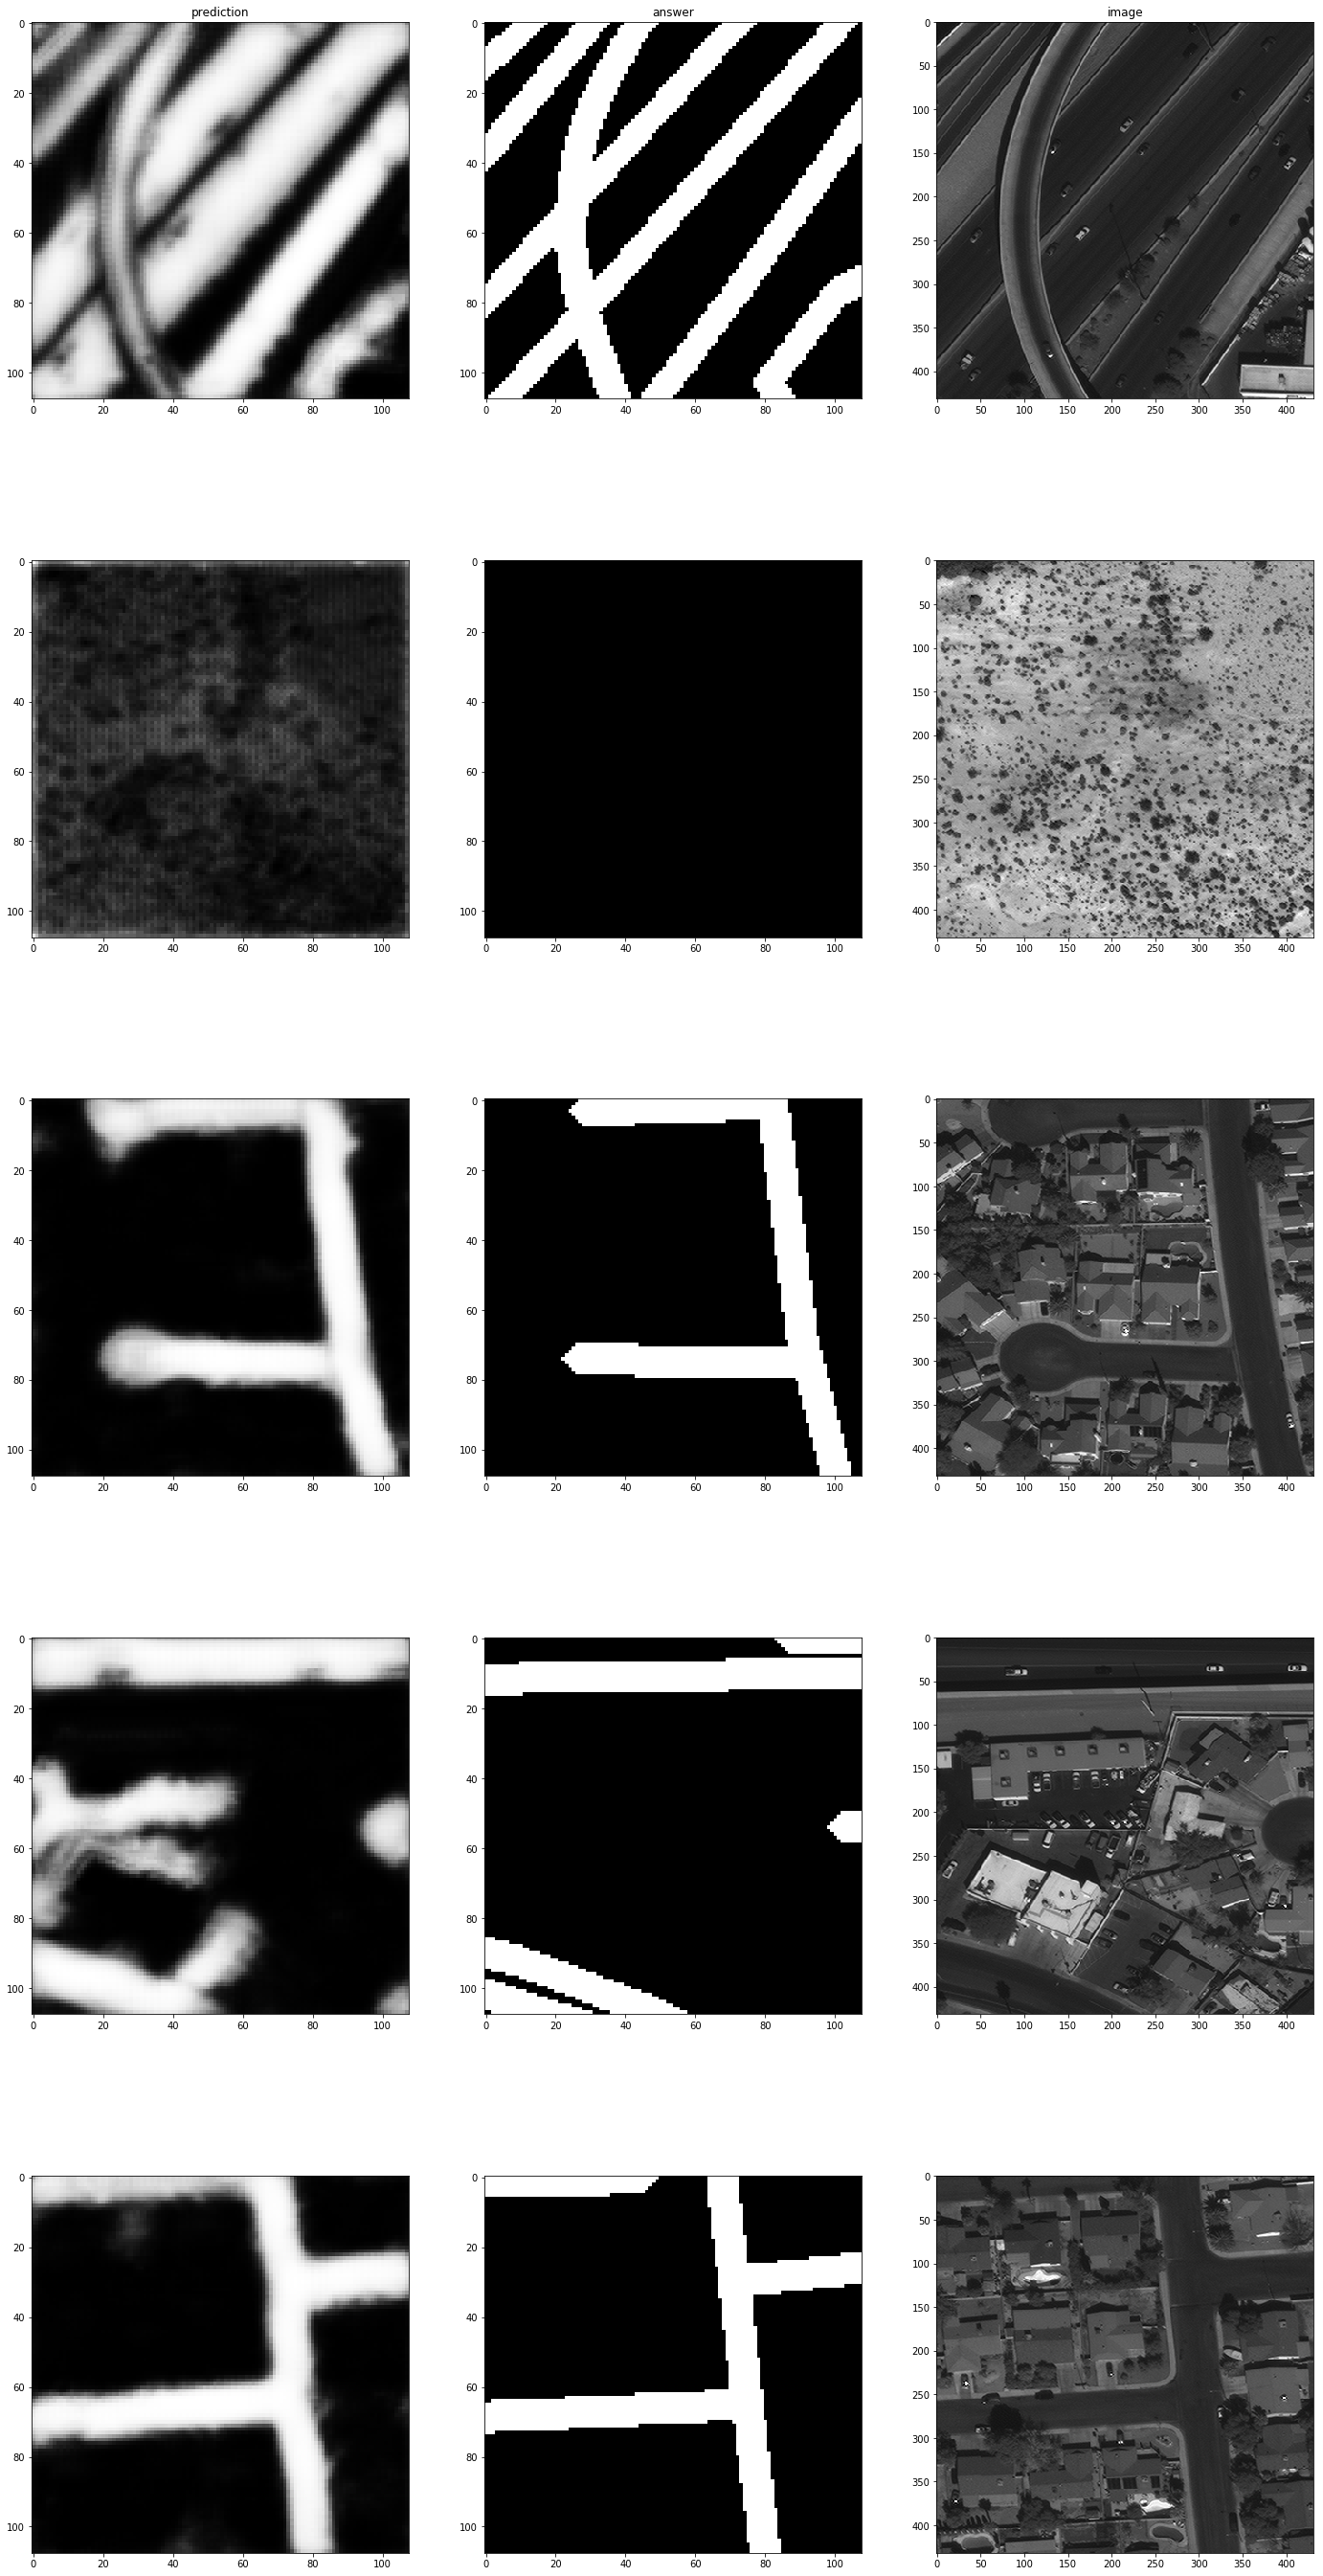

In [12]:
nimages = 5
g = Val_generator(nimages, tile_size)
([xMulVal, xPanVal], yVal) = next(g)
plt.figure(figsize=(24, 10*nimages))
pred = np.reshape(modelList[0].predict([xMulVal,xPanVal]),(nimages,tile_size[0],tile_size[1]))
for i in range(nimages):
    plt.subplot(nimages,3,i*3+1)
    plt.imshow(pred[i], cmap='gray')
    if i == 0:
        plt.title('prediction')
    
    plt.subplot(nimages,3,i*3+2)
    plt.imshow(np.reshape(yVal[i],(tile_size[0],tile_size[1])), cmap='gray')
    if i == 0:
        plt.title('answer')
    
    plt.subplot(nimages,3,i*3+3)
    plt.imshow(xPanVal[i][0], cmap='gray')
    if i == 0:
        plt.title('image')

In [14]:
modelList[0].save_weights('model')

In [15]:
train(0, batchsize=3, nepochs=10, timelimit=6*3600)

Epoch 1/10
 - 2501s - loss: 0.2356 - IoU_metrics: 0.5162 - val_loss: 0.2478 - val_IoU_metrics: 0.4732
Epoch 2/10
 - 2175s - loss: 0.2277 - IoU_metrics: 0.5273 - val_loss: 0.2638 - val_IoU_metrics: 0.4553
Epoch 3/10
 - 2133s - loss: 0.2255 - IoU_metrics: 0.5295 - val_loss: 0.2305 - val_IoU_metrics: 0.4560
Epoch 4/10
 - 2164s - loss: 0.2219 - IoU_metrics: 0.5362 - val_loss: 0.2454 - val_IoU_metrics: 0.4605
Epoch 5/10
 - 2106s - loss: 0.2194 - IoU_metrics: 0.5345 - val_loss: 0.2546 - val_IoU_metrics: 0.4777
Epoch 6/10
 - 2425s - loss: 0.2164 - IoU_metrics: 0.5358 - val_loss: 0.2599 - val_IoU_metrics: 0.4737
Epoch 7/10
 - 2591s - loss: 0.2188 - IoU_metrics: 0.5312 - val_loss: 0.2276 - val_IoU_metrics: 0.4572
Epoch 8/10
 - 2753s - loss: 0.2158 - IoU_metrics: 0.5370 - val_loss: 0.2382 - val_IoU_metrics: 0.4960
Epoch 9/10
 - 2302s - loss: 0.2155 - IoU_metrics: 0.5415 - val_loss: 0.2449 - val_IoU_metrics: 0.4619
Epoch 10/10
 - 2005s - loss: 0.2171 - IoU_metrics: 0.5389 - val_loss: 0.2702 - val

In [16]:
modelList[0].save_weights('model2')

I did 2 more dilatations to remove the black dots on the training set. I forgot to do those dillatations on the validation set. It doesn't affect the learning, but it makes that the validation_loss and validation_metrics are not good measures because the neural network with learn to make roads bigger than in the validation set.

I'm correcting this error now.

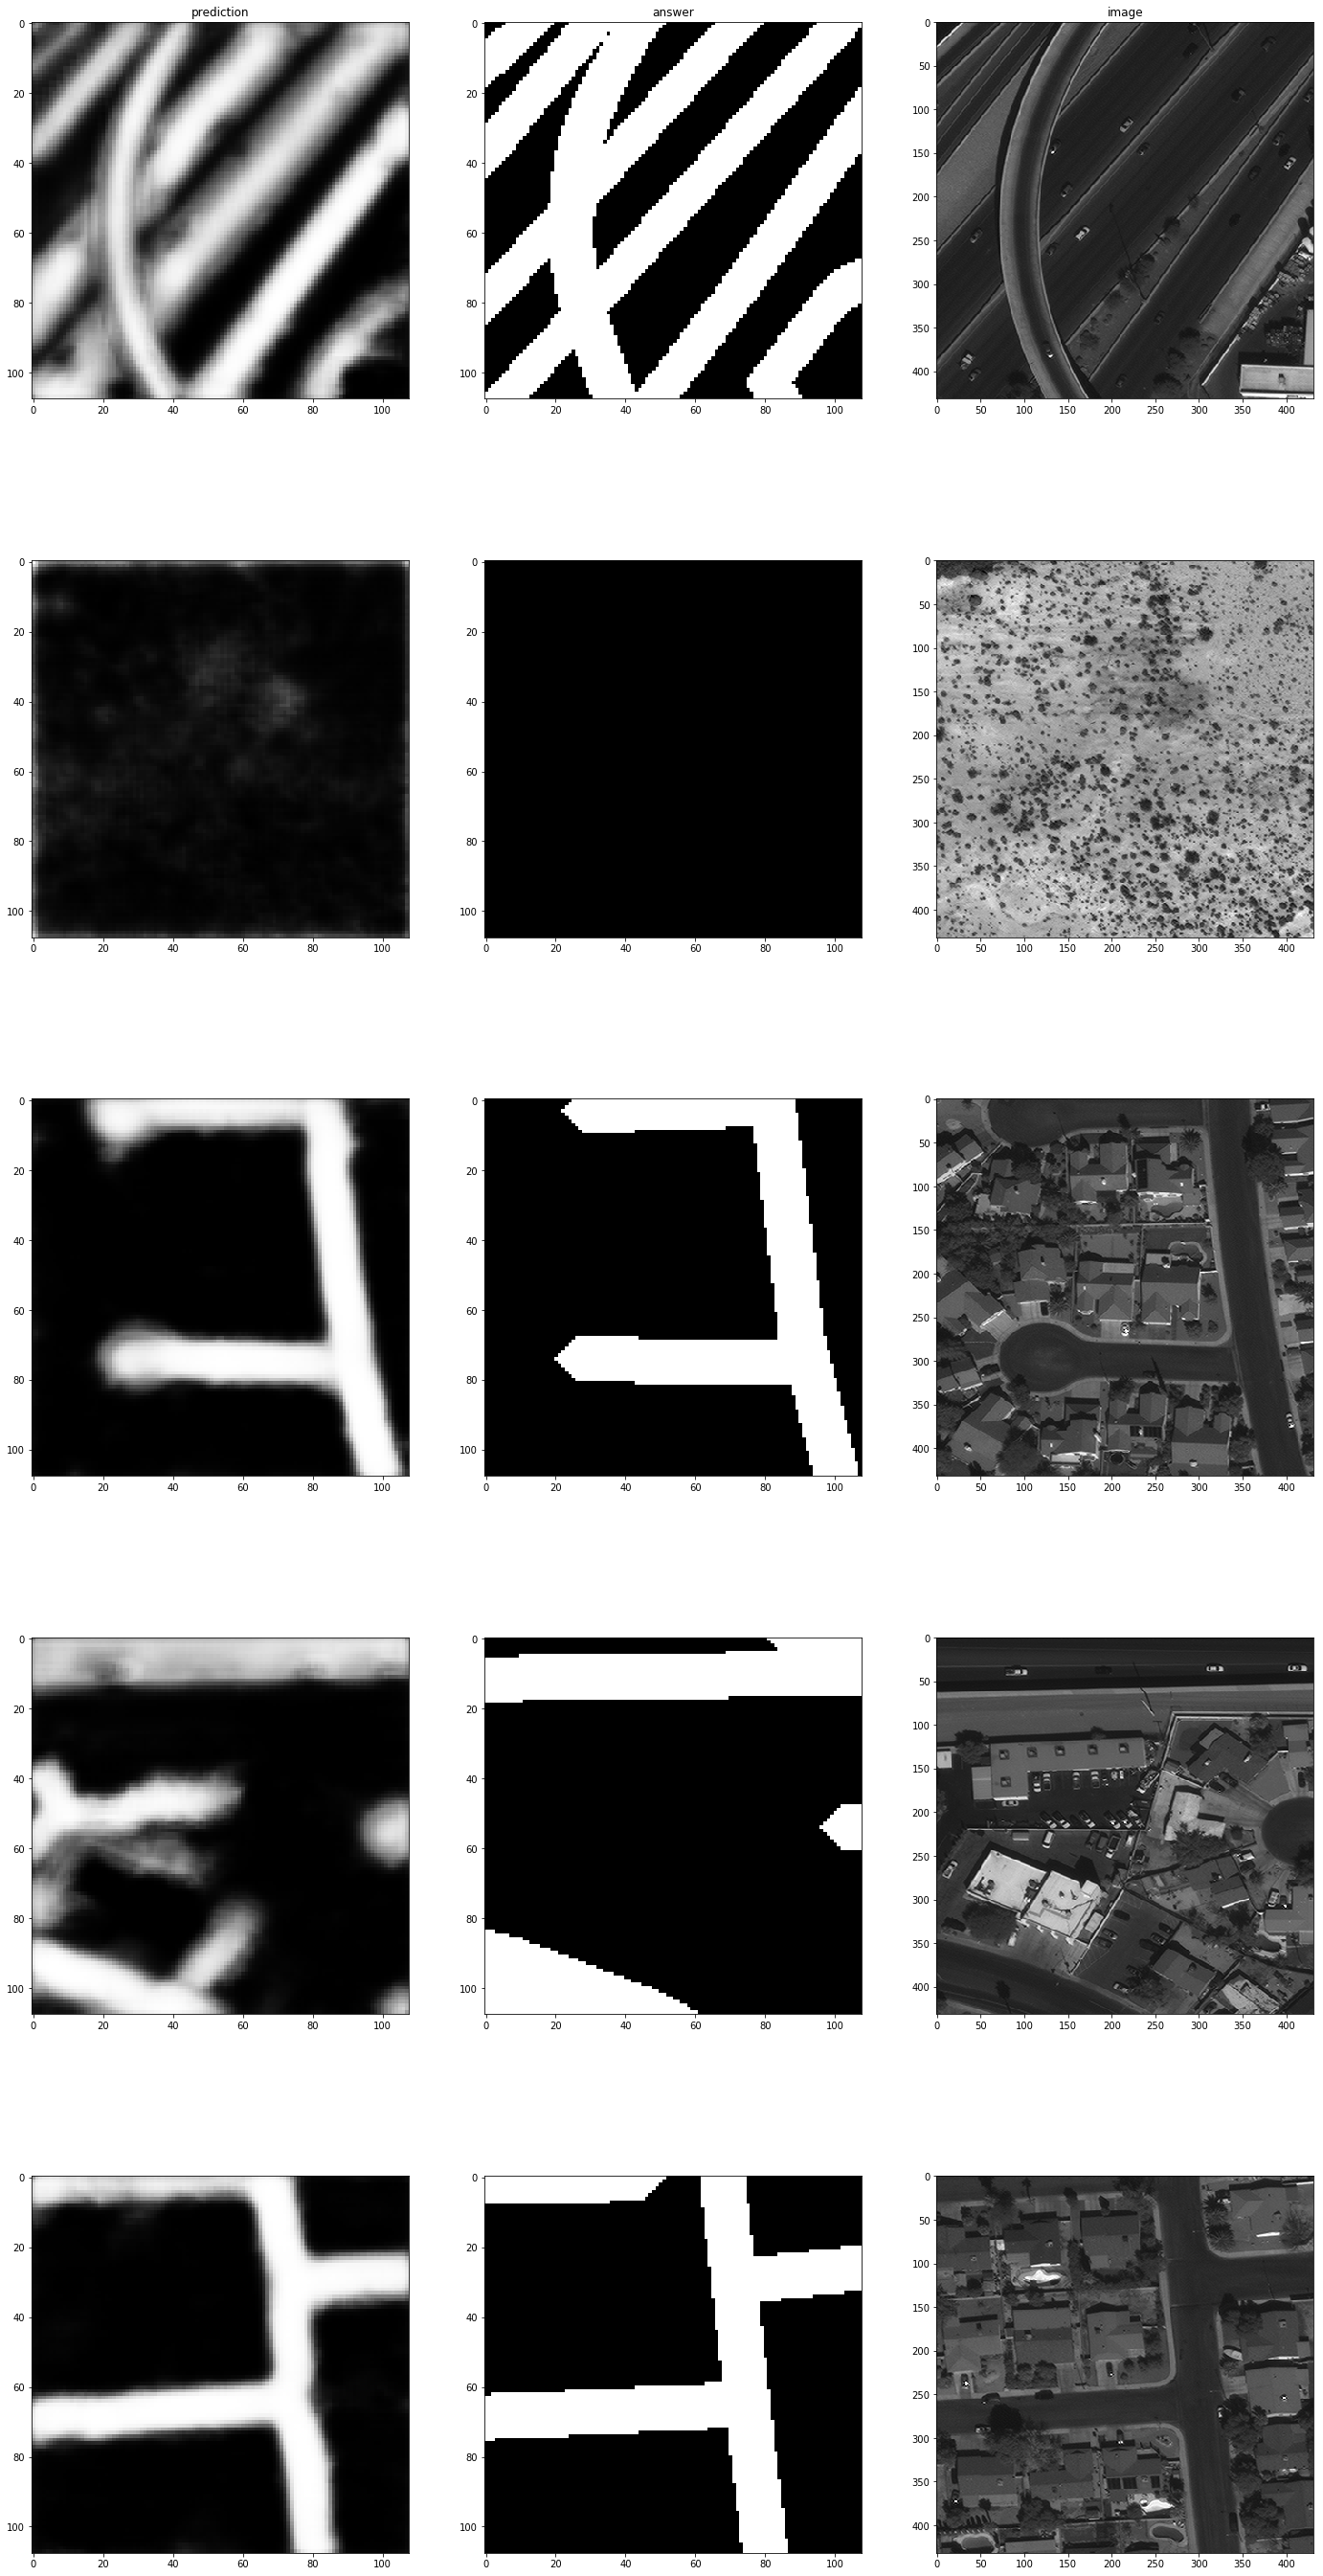

In [19]:
nimages = 5
g = Val_generator(nimages, tile_size)
([xMulVal, xPanVal], yVal) = next(g)
plt.figure(figsize=(24, 10*nimages))
pred = np.reshape(modelList[0].predict([xMulVal,xPanVal]),(nimages,tile_size[0],tile_size[1]))
for i in range(nimages):
    plt.subplot(nimages,3,i*3+1)
    plt.imshow(pred[i], cmap='gray')
    if i == 0:
        plt.title('prediction')
    
    plt.subplot(nimages,3,i*3+2)
    plt.imshow(np.reshape(yVal[i],(tile_size[0],tile_size[1])), cmap='gray')
    if i == 0:
        plt.title('answer')
    
    plt.subplot(nimages,3,i*3+3)
    plt.imshow(xPanVal[i][0], cmap='gray')
    if i == 0:
        plt.title('image')

In [31]:
train(0, batchsize=3, nepochs=10, timelimit=4*3600)

Epoch 1/10
 - 2095s - loss: 0.2169 - IoU_metrics: 0.5386 - val_loss: 0.2369 - val_IoU_metrics: 0.5281
Epoch 2/10
 - 1994s - loss: 0.2157 - IoU_metrics: 0.5434 - val_loss: 0.2285 - val_IoU_metrics: 0.5605
Epoch 3/10
 - 2351s - loss: 0.2177 - IoU_metrics: 0.5371 - val_loss: 0.2320 - val_IoU_metrics: 0.5523
Epoch 4/10
 - 2340s - loss: 0.2133 - IoU_metrics: 0.5450 - val_loss: 0.2261 - val_IoU_metrics: 0.5514
Epoch 5/10
 - 2446s - loss: 0.2138 - IoU_metrics: 0.5445 - val_loss: 0.2330 - val_IoU_metrics: 0.5780
Epoch 6/10
 - 2092s - loss: 0.2111 - IoU_metrics: 0.5447 - val_loss: 0.2393 - val_IoU_metrics: 0.5507
Epoch 7/10
 - 2082s - loss: 0.2107 - IoU_metrics: 0.5430 - val_loss: 0.2439 - val_IoU_metrics: 0.5664
Stopping after 14400 seconds.


In [33]:
train(0, batchsize=3, nepochs=1, timelimit=3600)

Epoch 1/1
 - 2081s - loss: 0.2070 - IoU_metrics: 0.5499 - val_loss: 0.2249 - val_IoU_metrics: 0.5373


In [34]:
train(0, batchsize=3, nepochs=1, timelimit=3600)

Epoch 1/1
 - 2083s - loss: 0.2126 - IoU_metrics: 0.5454 - val_loss: 0.2162 - val_IoU_metrics: 0.5593


In [42]:
modelList[0].save_weights('model3')

In [5]:
# I will stop saving history, anyway it's written and the history object got lost when my notebook died.

def loadModel():
    XMul = layers.Input(shape=(8,tile_size[0],tile_size[1]))
    XPan = layers.Input(shape=(1,4*tile_size[0],4*tile_size[1]))
    
    # Actual neural netowrk given by function NN
    Y = NN(XMul,XPan)
    
    model = Model(inputs=[XMul,XPan], outputs=Y)

    model.compile(optimizer='adam', metrics=[IoU_metrics],
                  loss='binary_crossentropy')
    model.load_weights('model3')
    modelList.append(model)
    
def train(i_model, batchsize=1, nepochs=10, timelimit=np.inf):
    time_callback = TimeHistory(timelimit)
    es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0., patience=10)
    modelList[i_model].fit_generator(generator(batchsize, tile_size),
                    steps_per_epoch=882*(325//tile_size[0])*(325//tile_size[1]) // batchsize,
                    epochs=nepochs, max_queue_size=2,
                    validation_data=Val_generator(batchsize, tile_size),
                    validation_steps=99*(325//tile_size[0])*(325//tile_size[1]) // batchsize,
                 verbose=2,callbacks=[time_callback, es])
    
loadModel()

In [6]:
train(0, batchsize=3, nepochs=1, timelimit=3600)

Epoch 1/1
 - 3163s - loss: 0.2092 - IoU_metrics: 0.5481 - val_loss: 0.2258 - val_IoU_metrics: 0.5325


In [7]:
train(0, batchsize=3, nepochs=100, timelimit=8*3600)

Epoch 1/100
 - 30146s - loss: 0.2103 - IoU_metrics: 0.5500 - val_loss: 0.2158 - val_IoU_metrics: 0.5596
Stopping after 28800 seconds.


In [8]:
modelList[0].save_weights('model4')

In [9]:
train(0, batchsize=3, nepochs=100, timelimit=3*3600)

Epoch 1/100
 - 2536s - loss: 0.2095 - IoU_metrics: 0.5506 - val_loss: 0.2196 - val_IoU_metrics: 0.5486
Epoch 2/100
 - 2118s - loss: 0.2090 - IoU_metrics: 0.5504 - val_loss: 0.2238 - val_IoU_metrics: 0.5566
Epoch 3/100
 - 2119s - loss: 0.2092 - IoU_metrics: 0.5499 - val_loss: 0.2163 - val_IoU_metrics: 0.5691
Epoch 4/100
 - 2263s - loss: 0.2095 - IoU_metrics: 0.5480 - val_loss: 0.2319 - val_IoU_metrics: 0.5181
Epoch 5/100
 - 2118s - loss: 0.2074 - IoU_metrics: 0.5538 - val_loss: 0.2175 - val_IoU_metrics: 0.5775
Stopping after 10800 seconds.


In [10]:
modelList[0].save_weights('model5')

Save pred2 here (for model5)

Continue with thinner target here (so that I can more easily distinguish between nearby road) since the network has difficulty to separate nearby roads sometime.

In [13]:
dillatation = 2 # Before I used 6 dillations (4 to get yWide, then 2 more after the rotation to remove the black spots created by the rotation)
def generator(batchsize, tile_size):
    while True:
        for i in range(nBatch):
            #print('  file', i)
            xMul = np.load(r'..\data\xMul'+str(i)+'.npy')
            xPan = np.load(r'..\data\xPan'+str(i)+'.npy')
            y = np.load(r'..\data\y325_'+str(i)+'.npy')[:,np.newaxis,:,:] # create a channel axis of 1
            xMul = (xMul - MeanMul[:,np.newaxis,np.newaxis])/StdMul[:,np.newaxis,np.newaxis]
            xPan = (xPan - MeanPan)/StdPan
            
            theta = np.random.uniform(-np.pi, np.pi,len(xMul))
            axis = np.random.randint(0, 3, len(xMul))# choose to not flip (0), flip x (1), flip y (2)
            x_start = np.random.randint(0, xMul.shape[2] - tile_size[0],len(xMul))
            y_start = np.random.randint(0, xMul.shape[3] - tile_size[1],len(xMul))
            
            xMul = trans(xMul,xMul.shape,theta,axis,x_start,y_start,tile_size)
            xPan = trans(xPan,xPan.shape,theta,axis,4*x_start,4*y_start,4*tile_size)
            y = trans(y,y.shape,theta,axis,x_start,y_start,tile_size)
            
            # do dilatations here
            for i in range(len(y)):
                for _ in range(dillatation):
                    y[i] = morphology.binary_dilation(y[i])
            
            # brightness is changed by multiplying with a constant
            # Multiplying all channel of xMul by a constant might not correspond to real change in brightness due to movement
            # of the sun, but it's the best approximation I can think of.
            u = np.random.normal(loc=1.02, scale=0.12, size=len(xMul))
            xPan = xPan*u[:,np.newaxis,np.newaxis,np.newaxis]
            xMul = xMul*u[:,np.newaxis,np.newaxis,np.newaxis]
            
            j=0
            while j<xMul.shape[0]:
                #print('    ',j, '/', xMul.shape[0])
                yield ([xMul[j:j+batchsize], xPan[j:j+batchsize]], y[j:j+batchsize].reshape((-1,tile_size[0]*tile_size[1])))
                j+= batchsize

nBatchVal = 11 # 11 batches of 9
def Val_generator(batchsize, tile_size):
    y = np.load(r'..\data\yVal325.npy')
    # do dilatations here
    for i in range(len(y)):
        for _ in range(dillatation):
            y[i] = morphology.binary_dilation(y[i])
    while True:
        jy = 0
        for batch in range(nBatchVal):
            xMul = np.load(r'..\data\xMulVal'+str(batch)+r'.npy')
            xPan = np.load(r'..\data\xPanVal'+str(batch)+r'.npy')
            xMul = (xMul - MeanMul[:,np.newaxis,np.newaxis])/StdMul[:,np.newaxis,np.newaxis]
            xPan = (xPan - MeanPan)/StdPan
            
            j=0
            while j<xMul.shape[0]:
                for ix in range(325//tile_size[0]):
                    for iy in range(325//tile_size[1]):
                        yield ([xMul[j:j+batchsize,:,ix*tile_size[0]:(ix+1)*tile_size[0],
                        iy*tile_size[1]:(iy+1)*tile_size[1]], 
                        xPan[j:j+batchsize,:,4*ix*tile_size[0]:4*(ix+1)*tile_size[0],4*iy*tile_size[1]:4*(iy+1)*tile_size[1]]], 
                        y[jy:jy+batchsize,ix*tile_size[0]:(ix+1)*tile_size[0],iy*tile_size[1]:(iy+1)*tile_size[1]]
                           .reshape((-1,tile_size[0]*tile_size[1])))
                j+= batchsize
                jy+= batchsize

In [ ]:
train(0, batchsize=3, nepochs=2, timelimit=2*3600)

Epoch 1/2


# Make predictions for all validation images

In [11]:
nBatchVal = 11 # 11 batches of 9
def finiteVal_generator(batchsize, tile_size):
    for batch in range(nBatchVal):
        print('  batch', batch)
        xMul = np.load(r'..\data\xMulVal'+str(batch)+r'.npy')
        xPan = np.load(r'..\data\xPanVal'+str(batch)+r'.npy')
        xMul = (xMul - MeanMul[:,np.newaxis,np.newaxis])/StdMul[:,np.newaxis,np.newaxis]
        xPan = (xPan - MeanPan)/StdPan

        j=0
        while j<xMul.shape[0]:
            #print('    j', j, xMul.shape[0])
            for ix in range(325//tile_size[0]):
                #print('      ix', ix)
                for iy in range(325//tile_size[1]):
                    #print('      iy', iy)
                    yield (j+batch*batchsize, ix, iy, [xMul[j:j+batchsize,:,ix*tile_size[0]:(ix+1)*tile_size[0],
                        iy*tile_size[1]:(iy+1)*tile_size[1]], 
                        xPan[j:j+batchsize,:,4*ix*tile_size[0]:4*(ix+1)*tile_size[0],4*iy*tile_size[1]:4*(iy+1)*tile_size[1]]])
            j+= batchsize

batchsize = 9
g = finiteVal_generator(batchsize, tile_size)
pred = np.empty((99,3,3,tile_size[0],tile_size[1]))
#i = 0
for (j, ix, iy, [xMulVal, xPanVal]) in g:
    #print("  ",j, ix, iy)
    pred[j:j+batchsize,ix,iy,:,:] = np.reshape(modelList[0].predict([xMulVal,xPanVal]),(batchsize,tile_size[0],tile_size[1]))
    #i += 1

  batch 0
  batch 1
  batch 2
  batch 3
  batch 4
  batch 5
  batch 6
  batch 7
  batch 8
  batch 9
  batch 10


In [12]:
np.save('pred2',pred)